#Import packages and libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import pickle
from sklearn.ensemble import RandomForestClassifier

#Paths' files

In [ ]:
train_path = "/content/drive/MyDrive/augmented_train/"
test_path = "/content/drive/MyDrive/augmented_test/"
mask_path ="/content/drive/MyDrive/augmented_masks/"

In [ ]:
f1 = len(os.listdir(train_path))
f2 =len(os.listdir(test_path))
print (f1,f2)
f2*100/f1

974 218


22.38193018480493

#Features extraction function

In [ ]:
def feature_extractor(path,mask_path):
    Dataset = pd.DataFrame()
    i =1 # for monitoring the operation process
    for image in os.listdir(path):  # iterate through each file
        #print(i)
        df = pd.DataFrame()
        if image.split('.')[0][:3] == 'Def': # first three letters of each defect type
            mask1 = cv2.imread(mask_path + image)
            mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
            ret,bi_mask = cv2.threshold(mask1,192,255,cv2.THRESH_BINARY)
            mask = cv2.resize(bi_mask, (105, 105))//255 #to make the classes confined between 1 and 0 only for each pixel
            df["label"] = mask.reshape(-1) # the label of each defected tile images is its binary mask
        #else:
            #df["label"] = np.zeros((100, 100)).reshape(-1) #if the image not for defected tile its label is (0)

            input_img = cv2.imread(path + image)  # Read images
            img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img,(105, 105))


            pixel_values = img.reshape(-1)/255.0
            df['Pixel_Value'] = pd.DataFrame(pixel_values)   #Pixel value itself as a feature
        #Defining the desired filter (feature).
        #Generate Gabor features

            l = 0

            Defult_kernel = cv2.getGaborKernel((3, 3), sigma = 1.0, theta = 0.0, lambd = 1.0, gamma  = 1.0, psi =0, ktype=cv2.CV_32F)
            Defult_Gabor = cv2.filter2D(img, cv2.CV_8UC3, Defult_kernel)
            Defult_Gabor = img.reshape(-1)/255.0
            df['Defult_Gabor'] = pd.DataFrame(Defult_Gabor)
            kernels = []  #Create empty list to hold all kernels that we will generate in a loop
            for theta in range(4):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi
                theta = theta / 4. * np.pi
                l +=1
                for sigma in (1, 3, 5):  #Sigma with values of 1 and 3
                  for lamda in (0.5, 1.0, 2.0):   #Range of wavelengths
                    for gamma in (0.05, 0.9):
                      gabor_label = 'Gabor_' + 'th' + str(l) + 'sg' + str(sigma) + 'lm' + str(lamda)  + 'ga' + str(gamma)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                       print(gabor_label)
                      ksize=3  #Try 15 for hidden image. Or 9 for others
                      phi = 0  #0.8 for hidden image. Otherwise leave it to 0
                      kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
                      kernels.append(kernel)
                  #Now filter the image and add values to a new column
                      fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                      filtered_img = fimg.reshape(-1)/255

                #cv2.imwrite('images/gabor_filtered_images/'+gabor_label+'.jpg', filtered_img.reshape(img.shape))

                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                #print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
            print(i)
            i += 1  #Increment for gabor column label


            Dataset = pd.concat([Dataset,df])

    return Dataset

#Extracting training set

In [ ]:
Training_data= feature_extractor(train_path,mask_path)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
#Training_data = Training_data[Training_data.label != 0]
X_train= Training_dataX_train= Training_data[['Pixel_Value',
 'Defult_Gabor',
 'Gabor_th2sg5lm2.0ga0.9',
 'Gabor_th4sg5lm2.0ga0.9',
 'Gabor_th2sg1lm1.0ga0.9',
 'Gabor_th2sg3lm2.0ga0.9',
 'Gabor_th4sg1lm1.0ga0.9',
 'Gabor_th4sg3lm2.0ga0.9',
 'Gabor_th1sg1lm2.0ga0.9',
 'Gabor_th2sg3lm0.5ga0.9',
 'Gabor_th2sg3lm1.0ga0.9',
 'Gabor_th2sg5lm0.5ga0.9',
 'Gabor_th2sg5lm1.0ga0.9',
 'Gabor_th3sg1lm2.0ga0.9',
 'Gabor_th4sg3lm0.5ga0.9',
 'Gabor_th4sg3lm1.0ga0.9',
 'Gabor_th4sg5lm0.5ga0.9',
 'Gabor_th4sg5lm1.0ga0.9',
 'Gabor_th2sg1lm2.0ga0.9',
 'Gabor_th4sg1lm2.0ga0.9',
 'Gabor_th2sg1lm0.5ga0.9',
 'Gabor_th4sg1lm0.5ga0.9']]
X_train.info()
#Scaling training set if needed
'''from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)'''

y_train = Training_data['label'].values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5292000 entries, 0 to 11024
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Pixel_Value             float64
 1   Defult_Gabor            float64
 2   Gabor_th2sg5lm2.0ga0.9  float64
 3   Gabor_th4sg5lm2.0ga0.9  float64
 4   Gabor_th2sg1lm1.0ga0.9  float64
 5   Gabor_th2sg3lm2.0ga0.9  float64
 6   Gabor_th4sg1lm1.0ga0.9  float64
 7   Gabor_th4sg3lm2.0ga0.9  float64
 8   Gabor_th1sg1lm2.0ga0.9  float64
 9   Gabor_th2sg3lm0.5ga0.9  float64
 10  Gabor_th2sg3lm1.0ga0.9  float64
 11  Gabor_th2sg5lm0.5ga0.9  float64
 12  Gabor_th2sg5lm1.0ga0.9  float64
 13  Gabor_th3sg1lm2.0ga0.9  float64
 14  Gabor_th4sg3lm0.5ga0.9  float64
 15  Gabor_th4sg3lm1.0ga0.9  float64
 16  Gabor_th4sg5lm0.5ga0.9  float64
 17  Gabor_th4sg5lm1.0ga0.9  float64
 18  Gabor_th2sg1lm2.0ga0.9  float64
 19  Gabor_th4sg1lm2.0ga0.9  float64
 20  Gabor_th2sg1lm0.5ga0.9  float64
 21  Gabor_th4sg1lm0.5ga0.9  float64
d

In [ ]:
Training_data.head()

,label,Pixel_Value,Defult_Gabor,Gabor_th1sg1lm0.5ga0.9,Gabor_th1sg1lm1.0ga0.9,Gabor_th1sg1lm2.0ga0.9,Gabor_th1sg3lm0.5ga0.9,Gabor_th1sg3lm1.0ga0.9,Gabor_th1sg3lm2.0ga0.9,Gabor_th1sg5lm0.5ga0.9,...,Gabor_th3sg5lm2.0ga0.9,Gabor_th4sg1lm0.5ga0.9,Gabor_th4sg1lm1.0ga0.9,Gabor_th4sg1lm2.0ga0.9,Gabor_th4sg3lm0.5ga0.9,Gabor_th4sg3lm1.0ga0.9,Gabor_th4sg3lm2.0ga0.9,Gabor_th4sg5lm0.5ga0.9,Gabor_th4sg5lm1.0ga0.9,Gabor_th4sg5lm2.0ga0.9
0,0,0.639216,0.639216,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.000000,0.356863,0.062745,0.188235,0.152941,0.000000,0.227451,0.129412,0.000000
1,0,0.709804,0.709804,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.078431,0.431373,0.145098,0.301961,0.231373,0.070588,0.345098,0.207843,0.070588
2,0,0.713725,0.713725,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.011765,0.411765,0.101961,0.200000,0.203922,0.000000,0.239216,0.176471,0.000000
3,0,0.686275,0.686275,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.000000,0.388235,0.074510,0.109804,0.184314,0.000000,0.141176,0.160784,0.000000
4,0,0.627451,0.627451,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.086275,0.388235,0.141176,0.286275,0.215686,0.082353,0.321569,0.192157,0.078431


In [ ]:
np.unique(y_train)

array([0, 1], dtype=uint8)

#Training the model

In [ ]:
RF_model = RandomForestClassifier()
#Calculating training time
t0 = time.time()
RF_model.fit(X_train,y_train)
Training_time = time.time()-t0
print("Training_time", Training_time)

Training_time 2948.610566854477


#Estimating each feature importance with sorting

In [ ]:
Feature_importance = {}
for score, name in zip(RF_model.feature_importances_, X_train.columns):
  Feature_importance[name] = round(score, 2)
sorted_Feature_importance = {k: v for k, v in sorted(Feature_importance.items(), key=lambda item: item[1],reverse=True)}
sorted_Feature_importance

{'Pixel_Value': 0.09,
 'Defult_Gabor': 0.09,
 'Gabor_th2sg1lm1.0ga0.9': 0.06,
 'Gabor_th4sg1lm1.0ga0.9': 0.06,
 'Gabor_th2sg3lm0.5ga0.9': 0.06,
 'Gabor_th2sg5lm0.5ga0.9': 0.06,
 'Gabor_th4sg3lm0.5ga0.9': 0.06,
 'Gabor_th4sg5lm0.5ga0.9': 0.06,
 'Gabor_th2sg3lm1.0ga0.9': 0.05,
 'Gabor_th2sg5lm1.0ga0.9': 0.05,
 'Gabor_th4sg3lm1.0ga0.9': 0.05,
 'Gabor_th4sg5lm1.0ga0.9': 0.05,
 'Gabor_th2sg1lm2.0ga0.9': 0.04,
 'Gabor_th4sg1lm2.0ga0.9': 0.04,
 'Gabor_th2sg5lm2.0ga0.9': 0.03,
 'Gabor_th4sg5lm2.0ga0.9': 0.03,
 'Gabor_th2sg3lm2.0ga0.9': 0.03,
 'Gabor_th4sg3lm2.0ga0.9': 0.03,
 'Gabor_th2sg1lm0.5ga0.9': 0.03,
 'Gabor_th4sg1lm0.5ga0.9': 0.03,
 'Gabor_th1sg1lm2.0ga0.9': 0.0,
 'Gabor_th3sg1lm2.0ga0.9': 0.0}

In [ ]:
import xgboost as xgb

In [ ]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic'
}

In [ ]:
XGB_model = xgb.XGBClassifier()

In [ ]:
t0 = time.time()
XGB_model.fit(X_train, y_train)
Training_time = time.time()-t0
print("Training_time", Training_time)

Training_time 1059.2956190109253


In [ ]:
Feature_importance = {}
for score, name in zip(XGB_model.feature_importances_, X_train.columns):
  Feature_importance[name] = round(score, 2)
sorted_Feature_importance = {k: v for k, v in sorted(Feature_importance.items(), key=lambda item: item[1],reverse=True)}
sorted_Feature_importance

{'Pixel_Value': 0.22,
 'Gabor_th4sg5lm0.5ga0.9': 0.1,
 'Gabor_th2sg5lm0.5ga0.9': 0.09,
 'Gabor_th2sg1lm2.0ga0.9': 0.09,
 'Gabor_th4sg1lm2.0ga0.9': 0.08,
 'Gabor_th2sg1lm0.5ga0.9': 0.07,
 'Gabor_th4sg1lm0.5ga0.9': 0.06,
 'Gabor_th2sg5lm1.0ga0.9': 0.04,
 'Gabor_th4sg3lm1.0ga0.9': 0.04,
 'Gabor_th2sg1lm1.0ga0.9': 0.03,
 'Gabor_th4sg1lm1.0ga0.9': 0.03,
 'Gabor_th2sg3lm1.0ga0.9': 0.03,
 'Gabor_th4sg5lm1.0ga0.9': 0.03,
 'Gabor_th2sg3lm0.5ga0.9': 0.02,
 'Gabor_th4sg3lm0.5ga0.9': 0.02,
 'Gabor_th2sg5lm2.0ga0.9': 0.01,
 'Gabor_th4sg5lm2.0ga0.9': 0.01,
 'Gabor_th2sg3lm2.0ga0.9': 0.01,
 'Gabor_th4sg3lm2.0ga0.9': 0.01,
 'Gabor_th1sg1lm2.0ga0.9': 0.01,
 'Gabor_th3sg1lm2.0ga0.9': 0.01,
 'Defult_Gabor': 0.0}

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_data = lgb.Dataset(X_train, label=y_train)

t0 = time.time()
LGB_model = lgb.train(params, train_data, num_boost_round=100)
Training_time = time.time()-t0
print("Training_time", Training_time)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.508535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training_time 122.20063042640686


In [ ]:
# Get feature importances
feature_importance = LGB_model.feature_importance()

# Get feature names
feature_names = LGB_model.feature_name()

# Create a feature importance dataframe
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                   Feature  Importance
0              Pixel_Value         546
16  Gabor_th4sg5lm0.5ga0.9         387
11  Gabor_th2sg5lm0.5ga0.9         359
19  Gabor_th4sg1lm2.0ga0.9         313
18  Gabor_th2sg1lm2.0ga0.9         283
21  Gabor_th4sg1lm0.5ga0.9         169
20  Gabor_th2sg1lm0.5ga0.9         158
6   Gabor_th4sg1lm1.0ga0.9         112
4   Gabor_th2sg1lm1.0ga0.9         107
12  Gabor_th2sg5lm1.0ga0.9          99
17  Gabor_th4sg5lm1.0ga0.9          76
10  Gabor_th2sg3lm1.0ga0.9          61
1             Defult_Gabor          61
15  Gabor_th4sg3lm1.0ga0.9          52
8   Gabor_th1sg1lm2.0ga0.9          52
14  Gabor_th4sg3lm0.5ga0.9          49
9   Gabor_th2sg3lm0.5ga0.9          34
13  Gabor_th3sg1lm2.0ga0.9          28
5   Gabor_th2sg3lm2.0ga0.9          16
7   Gabor_th4sg3lm2.0ga0.9          15
3   Gabor_th4sg5lm2.0ga0.9          14
2   Gabor_th2sg5lm2.0ga0.9           9


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
CB_model = CatBoostClassifier()
t0 = time.time()
CB_model.fit(X_train, y_train)
Training_time = time.time()-t0
print("Training_time", Training_time)

Learning rate set to 0.400793
0:	learn: 0.4079961	total: 4.6s	remaining: 1h 16m 35s
1:	learn: 0.3205912	total: 7.6s	remaining: 1h 3m 11s
2:	learn: 0.2961627	total: 10s	remaining: 55m 27s
3:	learn: 0.2859303	total: 12.6s	remaining: 52m 19s
4:	learn: 0.2814645	total: 15.2s	remaining: 50m 19s
5:	learn: 0.2786905	total: 19.5s	remaining: 53m 57s
6:	learn: 0.2771813	total: 22.3s	remaining: 52m 45s
7:	learn: 0.2762727	total: 24.7s	remaining: 51m 1s
8:	learn: 0.2752572	total: 27.2s	remaining: 49m 57s
9:	learn: 0.2741628	total: 30.1s	remaining: 49m 38s
10:	learn: 0.2733110	total: 34.9s	remaining: 52m 17s
11:	learn: 0.2725977	total: 37.7s	remaining: 51m 41s
12:	learn: 0.2723298	total: 40.4s	remaining: 51m 10s
13:	learn: 0.2718322	total: 42.5s	remaining: 49m 55s
14:	learn: 0.2713232	total: 43.8s	remaining: 47m 57s
15:	learn: 0.2709562	total: 45.2s	remaining: 46m 17s
16:	learn: 0.2704485	total: 47.6s	remaining: 45m 51s
17:	learn: 0.2701065	total: 49.8s	remaining: 45m 19s
18:	learn: 0.2699579	total

In [ ]:
Feature_importance = {}
for score, name in zip(CB_model.feature_importances_, X_train.columns):
  Feature_importance[name] = round(score, 2)
sorted_Feature_importance = {k: v for k, v in sorted(Feature_importance.items(), key=lambda item: item[1],reverse=True)}
sorted_Feature_importance

{'Pixel_Value': 12.61,
 'Gabor_th4sg5lm0.5ga0.9': 10.78,
 'Defult_Gabor': 8.91,
 'Gabor_th2sg5lm0.5ga0.9': 8.72,
 'Gabor_th2sg1lm1.0ga0.9': 8.63,
 'Gabor_th4sg1lm2.0ga0.9': 7.87,
 'Gabor_th2sg1lm2.0ga0.9': 6.22,
 'Gabor_th2sg1lm0.5ga0.9': 5.14,
 'Gabor_th4sg1lm1.0ga0.9': 4.27,
 'Gabor_th4sg1lm0.5ga0.9': 3.93,
 'Gabor_th4sg5lm1.0ga0.9': 3.5,
 'Gabor_th2sg5lm1.0ga0.9': 3.19,
 'Gabor_th4sg3lm0.5ga0.9': 2.71,
 'Gabor_th2sg3lm0.5ga0.9': 2.31,
 'Gabor_th2sg3lm1.0ga0.9': 2.25,
 'Gabor_th4sg3lm1.0ga0.9': 1.96,
 'Gabor_th2sg5lm2.0ga0.9': 1.77,
 'Gabor_th2sg3lm2.0ga0.9': 1.46,
 'Gabor_th4sg3lm2.0ga0.9': 1.31,
 'Gabor_th4sg5lm2.0ga0.9': 1.08,
 'Gabor_th1sg1lm2.0ga0.9': 0.72,
 'Gabor_th3sg1lm2.0ga0.9': 0.68}

#Extracting testing data

In [ ]:
Testing_data = feature_extractor(test_path,mask_path)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


In [ ]:
#Testing_data = Testing_data[Testing_data.label != 0]
X_test = Testing_data[['Pixel_Value',
 'Defult_Gabor',
 'Gabor_th2sg5lm2.0ga0.9',
 'Gabor_th4sg5lm2.0ga0.9',
 'Gabor_th2sg1lm1.0ga0.9',
 'Gabor_th2sg3lm2.0ga0.9',
 'Gabor_th4sg1lm1.0ga0.9',
 'Gabor_th4sg3lm2.0ga0.9',
 'Gabor_th1sg1lm2.0ga0.9',
 'Gabor_th2sg3lm0.5ga0.9',
 'Gabor_th2sg3lm1.0ga0.9',
 'Gabor_th2sg5lm0.5ga0.9',
 'Gabor_th2sg5lm1.0ga0.9',
 'Gabor_th3sg1lm2.0ga0.9',
 'Gabor_th4sg3lm0.5ga0.9',
 'Gabor_th4sg3lm1.0ga0.9',
 'Gabor_th4sg5lm0.5ga0.9',
 'Gabor_th4sg5lm1.0ga0.9',
 'Gabor_th2sg1lm2.0ga0.9',
 'Gabor_th4sg1lm2.0ga0.9',
 'Gabor_th2sg1lm0.5ga0.9',
 'Gabor_th4sg1lm0.5ga0.9'
]]
y_test = Testing_data['label'].values

In [ ]:
'''model_name = "CB_model"
pickle.dump(CB_model, open('/content/drive/MyDrive/Colab Notebooks/CB_Gabor1.pkl', 'wb'))'''

#Estimating model metrics

Accuracy RF_model=  0.9927479633828841
Precision RF_model=  0.9764257591704674
Recall RF_model=  0.9415838885808531
F1 Score RF_model=  0.9586883614565044 



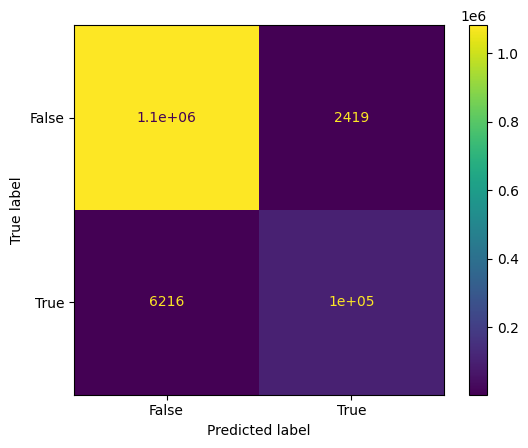

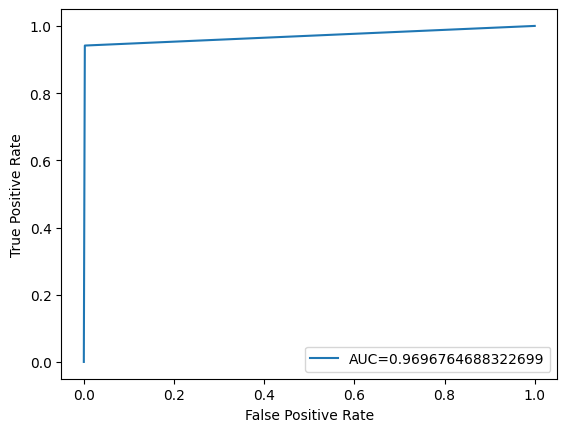

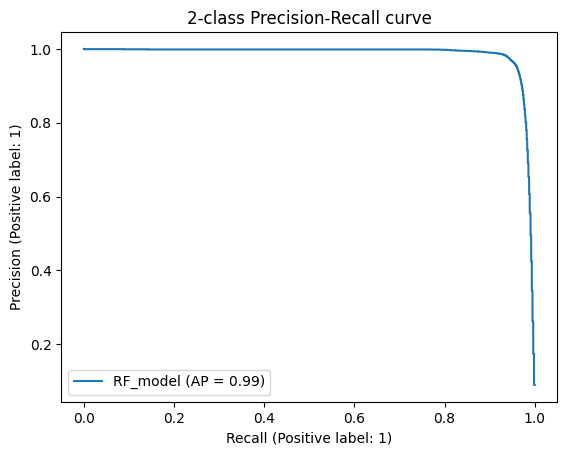

In [ ]:
test_prediction = RF_model.predict(X_test)
print ("Accuracy RF_model= ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision RF_model= ", metrics.precision_score(y_test, test_prediction))
print ("Recall RF_model= ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score RF_model= ", metrics.f1_score(y_test, test_prediction),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, X_test, y_test, name= "RF_model" )
_ = display.ax_.set_title("2-class Precision-Recall curve")

Accuracy XGB_model=  0.9250113378684808
Precision XGB_model=  0.8565181174510621
Recall XGB_model=  0.19326372769220648
F1 Score XGB_model=  0.31536815954730524 



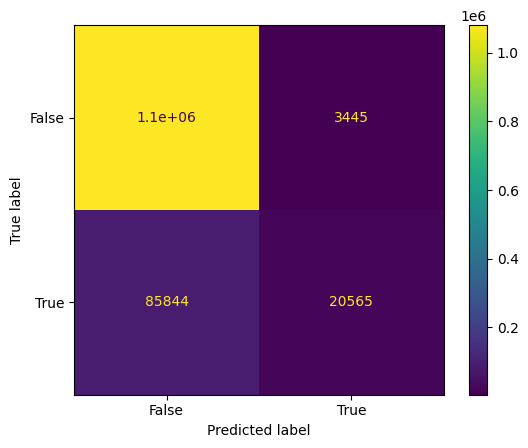

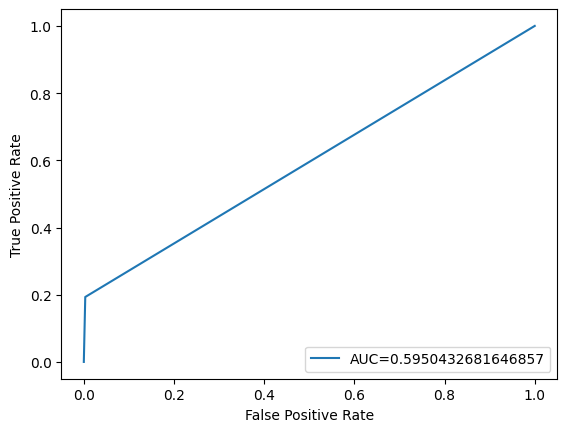

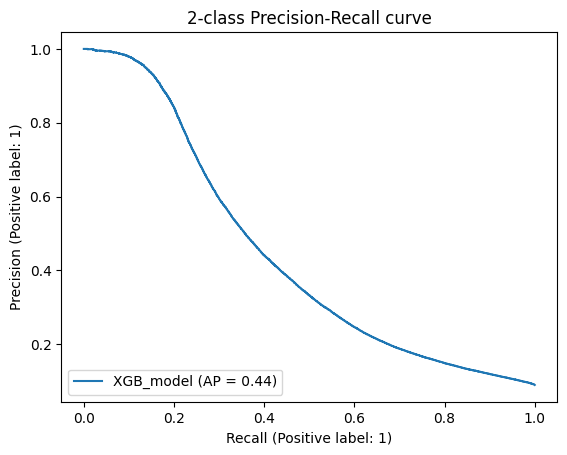

In [ ]:
test_prediction = XGB_model.predict(X_test)
print ("Accuracy XGB_model= ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision XGB_model= ", metrics.precision_score(y_test, test_prediction))
print ("Recall XGB_model= ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score XGB_model= ", metrics.f1_score(y_test, test_prediction),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  XGB_model, X_test, y_test, name= "XGB_model" )
_ = display.ax_.set_title("2-class Precision-Recall curve")

Accuracy CB_model=  0.9266423112454858
Precision CB_model=  0.8653964115933139
Recall CB_model=  0.2121343119472977
F1 Score CB_model=  0.3407425297940268 



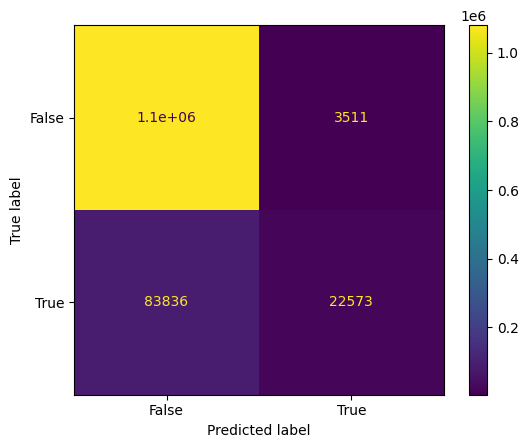

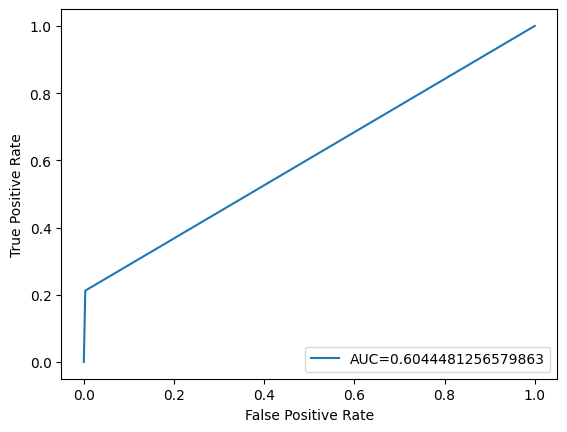

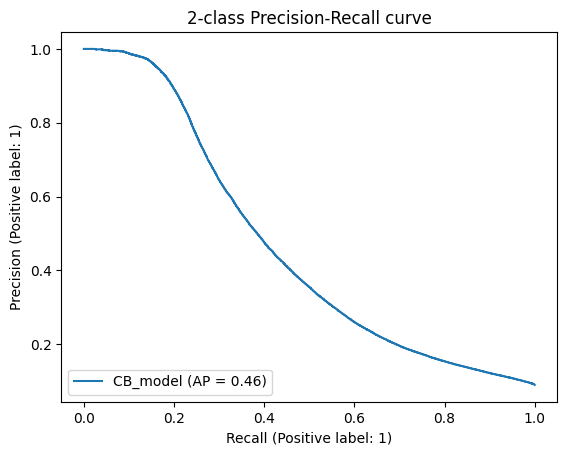

In [ ]:
test_prediction = CB_model.predict(X_test)
print ("Accuracy CB_model= ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision CB_model= ", metrics.precision_score(y_test, test_prediction))
print ("Recall CB_model= ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score CB_model= ", metrics.f1_score(y_test, test_prediction),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  CB_model, X_test, y_test, name= "CB_model" )
_ = display.ax_.set_title("2-class Precision-Recall curve")

Accuracy LGB_model=  0.9229184513311497
Precision LGB_model=  0.8669108056586736
Recall LGB_model=  0.16240167654991589
F1 Score LGB_model=  0.27355690461679716 



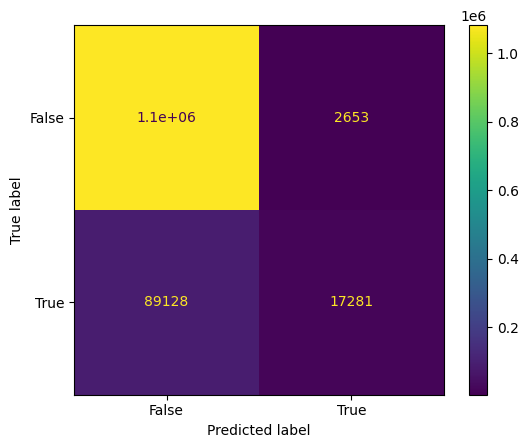

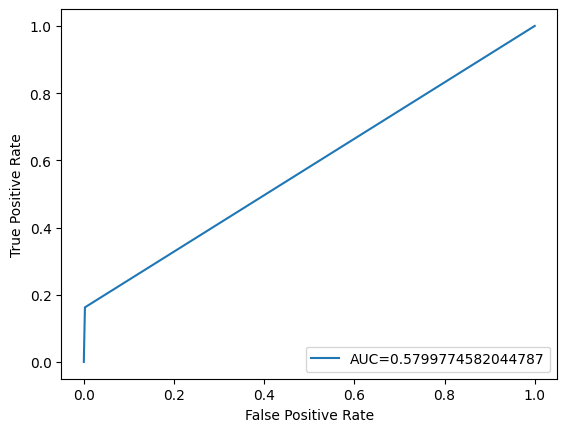

Average Precision: 0.21564121581006718


In [ ]:
test_prediction = LGB_model.predict(X_test)
y_pred_binary = (test_prediction > 0.5).astype(int)
y_test_binary = y_test.astype(int)
print ("Accuracy LGB_model= ", metrics.accuracy_score(y_test_binary, y_pred_binary))
print ("Precision LGB_model= ", metrics.precision_score(y_test_binary, y_pred_binary))
print ("Recall LGB_model= ", metrics.recall_score(y_test_binary, y_pred_binary))
print ("F1 Score LGB_model= ", metrics.f1_score(y_test_binary, y_pred_binary),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test_binary, y_pred_binary)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test_binary,  y_pred_binary)
auc = metrics.roc_auc_score(y_test_binary, y_pred_binary)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_binary)
ap = average_precision_score(y_test_binary, y_pred_binary)
print("Average Precision:", ap)

#Test pridiction's output

In [ ]:
def one_sample_feature_extractor (image):
  input_img = cv2.imread(image)  # Read images
  img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (105, 105))

  df= pd.DataFrame()
  pixel_values = img.reshape(-1)/255.0
  df['Pixel_Value'] = pd.DataFrame(pixel_values)   #Pixel value itself as a feature
        #Defining the desired filter (feature).
        #Generate Gabor features

  l = 0

  Defult_kernel = cv2.getGaborKernel((3, 3), sigma = 1.0, theta = 0.0, lambd = 1.0, gamma  = 1.0, psi =0, ktype=cv2.CV_32F)
  Defult_Gabor = cv2.filter2D(img, cv2.CV_8UC3, Defult_kernel)
  Defult_Gabor = img.reshape(-1)/255.0
  df['Defult_Gabor'] = pd.DataFrame(Defult_Gabor)
  for theta in range(4):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi
      theta = theta / 4. * np.pi
      l +=1
      for sigma in (1, 3, 5):  #Sigma with values of 1 and 3
          for lamda in (0.5, 1.0, 2.0):   #Range of wavelengths
              for gamma in (0.05, 0.9):
                  gabor_label = 'Gabor_' + 'th' + str(l) + 'sg' + str(sigma) + 'lm' + str(lamda)  + 'ga' + str(gamma)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                       print(gabor_label)
                  ksize=3  #Try 15 for hidden image. Or 9 for others
                  phi = 0  #0.8 for hidden image. Otherwise leave it to 0
                  kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
                  #Now filter the image and add values to a new column
                  fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                  filtered_img = fimg.reshape(-1)/255

                #cv2.imwrite('images/gabor_filtered_images/'+gabor_label+'.jpg', filtered_img.reshape(img.shape))

                  df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
  return df[['Pixel_Value',
 'Defult_Gabor',
 'Gabor_th2sg5lm2.0ga0.9',
 'Gabor_th4sg5lm2.0ga0.9',
 'Gabor_th2sg1lm1.0ga0.9',
 'Gabor_th2sg3lm2.0ga0.9',
 'Gabor_th4sg1lm1.0ga0.9',
 'Gabor_th4sg3lm2.0ga0.9',
 'Gabor_th1sg1lm2.0ga0.9',
 'Gabor_th2sg3lm0.5ga0.9',
 'Gabor_th2sg3lm1.0ga0.9',
 'Gabor_th2sg5lm0.5ga0.9',
 'Gabor_th2sg5lm1.0ga0.9',
 'Gabor_th3sg1lm2.0ga0.9',
 'Gabor_th4sg3lm0.5ga0.9',
 'Gabor_th4sg3lm1.0ga0.9',
 'Gabor_th4sg5lm0.5ga0.9',
 'Gabor_th4sg5lm1.0ga0.9',
 'Gabor_th2sg1lm2.0ga0.9',
 'Gabor_th4sg1lm2.0ga0.9',
 'Gabor_th2sg1lm0.5ga0.9',
 'Gabor_th4sg1lm0.5ga0.9']]

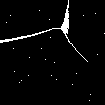

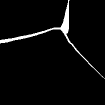

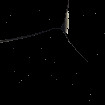

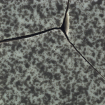

In [ ]:
test = one_sample_feature_extractor(test_path + 'Defr270crack6.png')
predicted = RF_model.predict(test)
predicted = predicted.reshape((105,105))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'Defr270crack6.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (105, 105))
cv2_imshow(mask)

print('\n')
predicted = np.array(predicted).astype('uint8')
src = cv2.resize(cv2.imread(test_path + 'Defr270crack6.png'),(105,105) )
masked_im = cv2.bitwise_and(src, src, mask=predicted)
cv2_imshow(masked_im)

print('\n')
cv2_imshow(src)


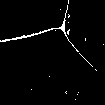

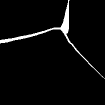

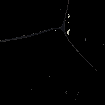

In [ ]:
predicted = XGB_model.predict(test)
predicted = predicted.reshape((105,105))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'Defr270crack6.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (105, 105))
cv2_imshow(mask)

print('\n')
predicted = np.array(predicted).astype('uint8')
src = cv2.resize(cv2.imread(test_path + 'Defr270crack6.png'),(105,105) )
masked_im = cv2.bitwise_and(src, src, mask=predicted)
cv2_imshow(masked_im)

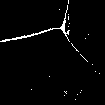

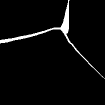

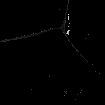

In [ ]:
predicted = CB_model.predict(test)
predicted = predicted.reshape((105,105))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'Defr270crack6.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (105, 105))
cv2_imshow(mask)

print('\n')
predicted = np.array(predicted).astype('uint8')
src = cv2.resize(cv2.imread(test_path + 'Defr270crack6.png'),(105,105) )
masked_im = cv2.bitwise_and(src, src, mask=predicted)
cv2_imshow(masked_im)

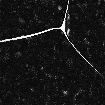

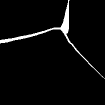

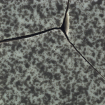

In [ ]:
predicted = LGB_model.predict(test)
predicted = predicted.reshape((105,105))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'Defr270crack6.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (105, 105))
cv2_imshow(mask)

print('\n')
predicted = np.array(predicted).astype('uint8')
src = cv2.resize(cv2.imread(test_path + 'Defr270crack6.png'),(105,105) )
masked_im = cv2.bitwise_and(src, src, mask=predicted)
cv2_imshow(masked_im)

In [ ]:
'''from yellowbrick.classifier import ROCAUC
print("Classes in the image are: ", np.unique(y_train))

#ROC curve for RF
roc_auc=ROCAUC(RF_model, classes=np.unique(y_train))  #Create object
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()'''

'from yellowbrick.classifier import ROCAUC\nprint("Classes in the image are: ", np.unique(y_train))\n\n#ROC curve for RF\nroc_auc=ROCAUC(RF_model, classes=np.unique(y_train))  #Create object\nroc_auc.fit(X_train, y_train)\nroc_auc.score(X_test, y_test)\nroc_auc.show()'